In [13]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F


In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'

In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    for result in executor.map(read_ladris_from_db, queries):
        comb_scenarios.update(result)

print(len(comb_scenarios))

8998


In [5]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)

In [6]:
df.head()

,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224,...,330399,331209,328168,335242,344419,341317,335083,341540,332615,332386
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_results

,0
0,4.183883
1,4.321939
2,4.791880
3,4.189669
4,4.973522
...,...
8993,3.600986
8994,3.848572
8995,3.790810
8996,3.709071


In [8]:
quantileDF = df_results[0].quantile([0.1, 0.15, 0.2, .25, 0.3, 0.35, 0.4, .45, .5, 0.55, .65, .75, 0.85, 0.95])
print(quantileDF)

### print quantile 0.65 of quantileDF
print(quantileDF[0.65])

0.10    0.000000
0.15    3.729948
0.20    3.834420
0.25    3.948825
0.30    4.099914
0.35    4.191592
0.40    4.244900
0.45    4.309894
0.50    4.389533
0.55    4.476327
0.65    4.715357
0.75    4.998629
0.85    5.397705
0.95    5.945152
Name: 0, dtype: float64
4.715356994444445


In [9]:
experiments = df
### Create outcomes as an array of df_results
outcomes = list(df_results[0].values)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example input data (6 samples, 6 features each)
inputs = torch.tensor([
    [0, 0, 1, 1, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1],
    [1, 0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0]
], dtype=torch.float32)

outputs = torch.tensor([2.3, 2.7, 3.4, 3.1, 2.9, 4.1], dtype=torch.float32)

# Hyperparameters
input_dim = inputs.shape[1]  # 6 features
embedding_dim = 16  # Embedding dimension
num_heads = 4
num_layers = 2
hidden_dim = 32
learning_rate = 0.001
num_epochs = 500

# Transformer-based regression model with explanation functionality
class TransformerRegressorWithAttention(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_heads, num_layers, hidden_dim):
        super(TransformerRegressorWithAttention, self).__init__()
        
        # Embedding layer for inputs
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Pooling layer to summarize sequence
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Final regression layer
        self.regressor = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # Embedding the input features
        x = self.embedding(x.long())  # Ensure the input is long before passing through embedding
        
        # Transformer input needs the shape: [seq_len, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)  # Correctly permute to [seq_len, batch_size, embedding_dim]
        
        # Transformer encoder
        x = self.transformer(x)  # Shape: [seq_len, batch_size, embedding_dim]
        
        # Pooling across the sequence dimension
        x = x.mean(dim=0)  # Global average pooling: Shape: [batch_size, embedding_dim]
        
        # Regression output
        x = self.regressor(x)  # Shape: [batch_size, 1]
        return x.squeeze(-1)
    
    def get_attention_weights(self, x):
        # Embedding the input features
        x = self.embedding(x.long())  # Ensure the input is long before passing through embedding
        
        # Transformer input needs the shape: [seq_len, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)  # Correctly permute to [seq_len, batch_size, embedding_dim]
        
        # Add sequence dimension for attention computation: [seq_len, 1, batch_size, embedding_dim]
        x = x.unsqueeze(1)  # Shape: [seq_len, 1, batch_size, embedding_dim]
        
        x = x.squeeze(1)

        print(x.shape)
        
        # Transformer encoder to get attention
        transformer_output = self.transformer(x)  # This directly gets the output from the transformer
        
        # Attention weights: [seq_len, batch_size, num_heads, seq_len]
        attention_weights = transformer_output.transpose(0,1)
        
        return attention_weights

# Model, loss, and optimizer
model = TransformerRegressorWithAttention(input_dim, embedding_dim, num_heads, num_layers, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Logging
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Testing and analysis
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(inputs)
    print("\nPredictions:", test_predictions.numpy())


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [50/500], Loss: 0.3192
Epoch [100/500], Loss: 0.3116
Epoch [150/500], Loss: 0.2477
Epoch [200/500], Loss: 0.1630
Epoch [250/500], Loss: 0.1779
Epoch [300/500], Loss: 0.1621
Epoch [350/500], Loss: 0.1624
Epoch [400/500], Loss: 0.1502
Epoch [450/500], Loss: 0.1327
Epoch [500/500], Loss: 0.1645

Predictions: [2.5153105 2.5153105 3.4444537 3.444454  3.4444537 3.444454 ]


In [33]:
# Testing and analysis
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(inputs)
    print("\nPredictions:", test_predictions.numpy())
    
    # Extract attention weights
    attention_weights = model.get_attention_weights(inputs)
    
    # Analyze and report patterns
    seq_len = inputs.shape[1]
    for i in range(inputs.shape[0]):  # Loop over each input sample
        print(f"\nAnalyzing Sample {i+1}: {inputs[i].numpy()}")
        
        sample_attention = attention_weights[:, i]

        # Calculate average attention weights per feature
        avg_attention = sample_attention.mean(dim=-1)#.detach().numpy()  # Shape: [num_heads, seq_len]
        
        print(sample_attention.shape)
        print(avg_attention.shape)

        print(type(avg_attention))
        avg_attention = avg_attention.detach().numpy()

        print(avg_attention)

        # Report top contributing features
        top_features = avg_attention.argsort()[-3:][::-1]  # Top 3 contributing features
        print(f"Top Contributing Features (Indices): {top_features}")
        print(f"Attention Weights for top features: {avg_attention}")



Predictions: [2.5153105 2.5153105 3.4444537 3.444454  3.4444537 3.444454 ]
torch.Size([6, 6, 16])

Analyzing Sample 1: [0. 0. 1. 1. 0. 0.]
torch.Size([6, 16])
torch.Size([6])
<class 'torch.Tensor'>
[ 0.00576869  0.00202399 -0.00180055  0.00442822 -0.0018006   0.00442822]
Top Contributing Features (Indices): [0 5 3]
Attention Weights for top features: [ 0.00576869  0.00202399 -0.00180055  0.00442822 -0.0018006   0.00442822]

Analyzing Sample 2: [1. 0. 0. 1. 0. 0.]
torch.Size([6, 16])
torch.Size([6])
<class 'torch.Tensor'>
[ 0.00576869  0.00576869 -0.00180055  0.00442822  0.00442821 -0.00180055]
Top Contributing Features (Indices): [1 0 3]
Attention Weights for top features: [ 0.00576869  0.00576869 -0.00180055  0.00442822  0.00442821 -0.00180055]

Analyzing Sample 3: [1. 1. 1. 0. 0. 0.]
torch.Size([6, 16])
torch.Size([6])
<class 'torch.Tensor'>
[ 0.00202399  0.00576869 -0.00180055  0.00442822 -0.0018006  -0.00180055]
Top Contributing Features (Indices): [1 3 0]
Attention Weights for to

In [38]:
#avg_attention
### get the top 3 features of avg_attention
print(model.embedding.weight[0])


tensor([ 1.4994,  0.6844, -1.6173, -0.0868, -0.4265,  3.1194,  0.8946, -0.0707,
         1.8802, -0.0592,  0.1951,  0.5570,  0.8786,  0.7869, -0.4481, -1.3754],
       grad_fn=<SelectBackward0>)


In [2]:
# After training
model.eval()
with torch.no_grad():
    predictions = model(inputs)
    #attention_weights = model.attention_weights  # List of attention weights for each layer


In [32]:
### convert experiments and outcomes to one hot encoded data
binary_input = experiments.values
one_hot_encoded = torch.nn.functional.one_hot(torch.tensor(binary_input), num_classes=2).numpy()
print(one_hot_encoded[0])
print(len(one_hot_encoded[0]), len(one_hot_encoded))


[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
2295 8998


In [33]:
embedding = nn.Embedding(2, embedding_dim=4)
binary_tensor = torch.tensor(binary_input)
embedded_input = embedding(binary_tensor)
print(embedded_input[0])
print(len(embedded_input[0]), len(embedded_input))

tensor([[ 0.8078, -0.1304,  0.5871,  0.1809],
        [ 0.8078, -0.1304,  0.5871,  0.1809],
        [ 0.8078, -0.1304,  0.5871,  0.1809],
        ...,
        [-1.9238, -0.3306,  0.4855,  1.9977],
        [-1.9238, -0.3306,  0.4855,  1.9977],
        [-1.9238, -0.3306,  0.4855,  1.9977]], grad_fn=<SelectBackward0>)
2295 8998


In [34]:
sequence_representation = binary_input + 1
print(sequence_representation[0])
print(len(sequence_representation[0]), len(sequence_representation))

[2 2 2 ... 1 1 1]
2295 8998


In [35]:
binary_tensor = torch.tensor(binary_input)
feature_groups = [[0,1],[2,3]]
multi_hot_encoded = torch.cat([binary_tensor[group] for group in feature_groups], dim=0)
print(multi_hot_encoded[0])
print(len(multi_hot_encoded[0]), len(multi_hot_encoded))

tensor([1, 1, 1,  ..., 0, 0, 0])
2295 4


In [36]:
binary_tensor = torch.tensor(binary_input)
print(binary_tensor.shape)
active_features = [torch.where(row==1)[0].tolist() for row in binary_tensor]
print(active_features[0])
print(len(active_features[0]), len(active_features))

torch.Size([8998, 2295])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
78 8998


In [37]:
print(binary_tensor.shape[1])
print(num_features)

2295
4


In [38]:
embedding_dim  = 32
binary_input = experiments.values
binary_tensor = torch.tensor(binary_input)
num_features = binary_tensor.shape[1]

embedding = nn.Embedding(num_features, embedding_dim)

aggregated_emebeddings = [
    embedding(torch.tensor(features)).mean(dim=0) if len(features) > 0 else torch.zeros(embedding_dim)
    for features in active_features
]

aggregated_emebeddings = torch.stack(aggregated_emebeddings)
print(aggregated_emebeddings.shape)

torch.Size([8998, 32])


In [39]:
print(f"Active features: {len(active_features)}")
count = 0
max_f = 0
for features in active_features:
    if any(f >= num_features or f < 0 for f in features):
        print(f"Invalid feature indices found: {len(features)}")              
    count += 1

print(count)


Active features: 8998
8998


In [40]:
class FeatureCombinationModel(nn.Module):
    def __init__(self, num_features, embedding_dim, output_dim):
        super(FeatureCombinationModel, self).__init__()
        self.embedding = nn.Embedding(num_features, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        # Aggregate embeddings of active features
        aggregated_embeddings = []
        for features in x:
            if len(features) > 0:
                feature_indices = torch.tensor(features)
                feature_indices = feature_indices.clamp(0, self.embedding.num_embeddings - 1)  # Clamp indices
                embeddings = self.embedding(feature_indices)
                aggregated_embeddings.append(embeddings.mean(dim=0))
            else:
                aggregated_embeddings.append(torch.zeros(self.embedding.embedding_dim))
        
        aggregated_embeddings = torch.stack(aggregated_embeddings)
        output = self.fc(aggregated_embeddings)
        return output

# Instantiate model
model = FeatureCombinationModel(num_features=num_features, embedding_dim=32, output_dim=1)

# Forward pass
output = model(active_features)
print(output)

tensor([[0.0878],
        [0.1837],
        [0.0684],
        ...,
        [0.3209],
        [0.1477],
        [0.1477]], grad_fn=<AddmmBackward0>)


In [103]:
class AttentionFeatureModel(nn.Module):
    def __init__(self, num_features, embedding_dim, output_dim, num_heads=4):
        super(AttentionFeatureModel, self).__init__()
        self.embedding = nn.Embedding(num_features, embedding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        # Aggregate embeddings of active features
        max_len = max(len(features) for features in x)  # Find max sequence length
        padded_features = torch.zeros(len(x), max_len, self.embedding.embedding_dim)
        attention_mask = torch.ones(len(x), max_len) * -float('inf')  # Default mask for attention
        
        for i, features in enumerate(x):
            if len(features) > 0:
                feature_indices = torch.tensor(features)
                feature_indices = feature_indices.clamp(0, self.embedding.num_embeddings - 1)  # Clamp indices
                embeddings = self.embedding(feature_indices)
                
                # Fill padded features and attention mask
                padded_features[i, :len(embeddings), :] = embeddings
                attention_mask[i, :len(embeddings)] = 0  # Mask valid positions
        
        # Attention mechanism
        attn_output, attn_weights = self.attention(
            padded_features, 
            padded_features, 
            padded_features,
            key_padding_mask=attention_mask.bool()
        )
        aggregated = attn_output.mean(dim=1)  # Aggregate attention output

        # Output layer
        output = self.fc(aggregated)
        return output, attn_weights

# Instantiate model
attention_model = AttentionFeatureModel(num_features=num_features, embedding_dim=32, output_dim=1)



In [ ]:
# Forward pass
output, weights = attention_model(active_features)
print(output, weights)

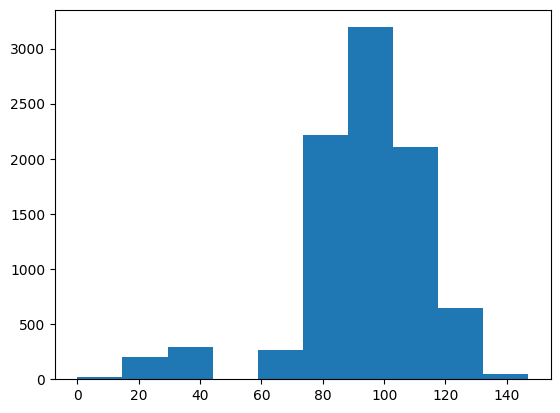

In [205]:
### plot histogram that represents the length of the active features
### get the length of each active feature
active_features_lengths = [len(row) for row in active_features]
plt.hist(active_features_lengths)
plt.show()

In [65]:
print(len(binary_input))
target_output = torch.tensor(df_results[0].values)
target_output = torch.tensor(target_output, dtype=torch.float32)
binary_tensor = torch.tensor(binary_input)



8998


/tmp/ipykernel_919784/13327173.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_output = torch.tensor(target_output, dtype=torch.float32)


In [66]:
dataset = TensorDataset(binary_tensor, target_output)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [67]:
import torch.optim as optim

output_dim = 1

# Example for FeatureCombinationModel
model = FeatureCombinationModel(num_features, embedding_dim, output_dim)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [68]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        # Prepare active_features from binary_input_batch
        active_features_batch = [
            torch.where(row == 1)[0].tolist() for row in binary_input_batch
        ]

        # Forward pass
        predictions = model(active_features_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")


Epoch 1/50, Loss: 12.730362611459501
Epoch 2/50, Loss: 3.261292077125387
Epoch 3/50, Loss: 3.0214132180450655
Epoch 4/50, Loss: 2.9292367136647517
Epoch 5/50, Loss: 2.855521414930939
Epoch 6/50, Loss: 2.8040145889241646
Epoch 7/50, Loss: 2.758265015504039
Epoch 8/50, Loss: 2.7042405524997846
Epoch 9/50, Loss: 2.660878027584536
Epoch 10/50, Loss: 2.624336950745143
Epoch 11/50, Loss: 2.5891525773925985
Epoch 12/50, Loss: 2.5721918758771096
Epoch 13/50, Loss: 2.5251267527012113
Epoch 14/50, Loss: 2.506297409745818
Epoch 15/50, Loss: 2.465899383556758
Epoch 16/50, Loss: 2.4432529289248985
Epoch 17/50, Loss: 2.4207902514765447
Epoch 18/50, Loss: 2.3982127562482307
Epoch 19/50, Loss: 2.3706941832887365
Epoch 20/50, Loss: 2.34938227834431
Epoch 21/50, Loss: 2.331463288542227
Epoch 22/50, Loss: 2.30646324749534
Epoch 23/50, Loss: 2.2886809357937348
Epoch 24/50, Loss: 2.279146305001374
Epoch 25/50, Loss: 2.2582635556129698
Epoch 26/50, Loss: 2.2463123715938407
Epoch 27/50, Loss: 2.2387435584203

In [70]:
attn_model = AttentionFeatureModel(num_features, embedding_dim, output_dim)

criterion = nn.MSELoss()  # Loss function for regression
optimizer = optim.Adam(attn_model.parameters(), lr=0.001)  # Adjust learning rate if needed

In [71]:
num_epochs = 50

for epoch in range(num_epochs):
    attn_model.train()  # Set model to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = attn_model(binary_input_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

/tmp/ipykernel_919784/1566264484.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_indices = torch.tensor(features)


Epoch 1/50, Loss: 3.655454892638727
Epoch 2/50, Loss: 3.046500346445023
Epoch 3/50, Loss: 3.0730649313182696
Epoch 4/50, Loss: 3.0696944902974663
Epoch 5/50, Loss: 3.068758174459985
Epoch 6/50, Loss: 3.0727536885450917
Epoch 7/50, Loss: 3.0652347092932843
Epoch 8/50, Loss: 3.0431945845484734
Epoch 9/50, Loss: 3.044002404978089
Epoch 10/50, Loss: 3.0489693722615003
Epoch 11/50, Loss: 3.078918237424066
Epoch 12/50, Loss: 3.059096540330995
Epoch 13/50, Loss: 3.0629026344481933
Epoch 14/50, Loss: 3.0572465205868933
Epoch 15/50, Loss: 3.065705267461479
Epoch 16/50, Loss: 3.0773804445638726
Epoch 17/50, Loss: 3.0465139873484346
Epoch 18/50, Loss: 3.052098202789929
Epoch 19/50, Loss: 3.056984438963816
Epoch 20/50, Loss: 3.0559719855903733
Epoch 21/50, Loss: 3.0674190379626363
Epoch 22/50, Loss: 3.0647737430342548
Epoch 23/50, Loss: 3.061633567438058
Epoch 24/50, Loss: 3.0607317844603923
Epoch 25/50, Loss: 3.042762963695729
Epoch 26/50, Loss: 3.061188892269811
Epoch 27/50, Loss: 3.067203262596

In [100]:
attn_model

AttentionFeatureModel(
  (embedding): Embedding(2295, 32)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [76]:
### Save the attn_model to file
torch.save(attn_model.state_dict(), 'attn_model.pth')
torch.save(model.state_dict(), 'feature_model.pth')



In [111]:
attn_model = AttentionFeatureModel(num_features, embedding_dim, output_dim)

### Load the model from file
attn_model.load_state_dict(torch.load('attn_model.pth'))
### laod the feature model from file
model.load_state_dict(torch.load('feature_model.pth'))


/tmp/ipykernel_919784/1738869584.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_model.load_state_dict(torch.load('attn_model.pth'))
/tmp/ipykernel_919784/173886958

<All keys matched successfully>

In [112]:
attn_model.eval()

AttentionFeatureModel(
  (embedding): Embedding(2295, 32)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [113]:
### predict a single scenario
scenario = torch.tensor(binary_input[1])
active_features = torch.where(scenario == 1)[0].tolist()
print(active_features)
predictions = attn_model([active_features])
print(predictions)




[16, 30, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
(tensor([[0.5937]], grad_fn=<AddmmBackward0>), tensor([[[0.0069, 0.0055, 0.0031,  ..., 0.0093, 0.0088, 0.0133],
         [0.0080, 0.0083, 0.0071,  ..., 0.0101, 0.0128, 0.0119],
         [0.0106, 0.0110, 0.0254,  ..., 0.0055, 0.0051, 0.0063],
         ...,
         [0.0124, 0.0099, 0.0117,  ..., 0.0084, 0.0109, 0.0081],
         [0.0065, 0.0054, 0.0308,  ..., 0.0070, 0.0046, 0.0029],
         [0.0093, 0.0053, 0.0056,  ..., 0.0146, 0.0130, 0.0106]]],
       grad_fn=<MeanBackward1>))


In [114]:
embedding_weights = model.embedding.weight.detach().cpu().numpy()

print("Embedding wewights shape:", embedding_weights.shape)

Embedding wewights shape: (2295, 32)


In [115]:
t_binary_input = torch.tensor(binary_input, dtype=torch.int64)

In [116]:
t_binary_input

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [117]:
attn_model.eval()
with torch.no_grad():
    input_example = t_binary_input[0].unsqueeze(0)  # Single input
    transformer_output, attention_weights = attn_model(input_example)
    print("Attention weights shape:", attention_weights.shape)

Attention weights shape: torch.Size([1, 2295, 2295])


/tmp/ipykernel_919784/2060239279.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_indices = torch.tensor(features)


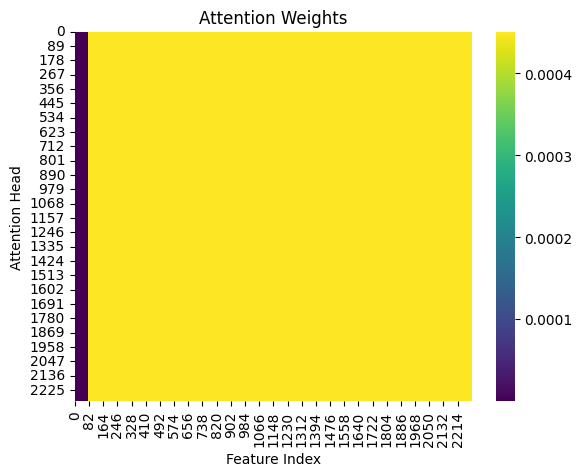

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume attention_weights is of shape (1, num_features) or (num_heads, num_features)
attention_weights_np = attention_weights.squeeze().numpy()  # Remove batch dimension

sns.heatmap(attention_weights_np, cmap="viridis")
plt.title("Attention Weights")
plt.xlabel("Feature Index")
plt.ylabel("Attention Head")
plt.show()

In [120]:
attention_weights_np[0]

array([1.0466510e-09, 1.0466510e-09, 1.0466510e-09, ..., 4.5105990e-04,
       4.5105990e-04, 4.5105995e-04], dtype=float32)

In [159]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.5]]
low_results = df_results[df_results[0] <= quantileDF[0.5]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.5]]
low_inputs = experiments[df_results[0] <= quantileDF[0.5]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))

4499
4499
4499
4499


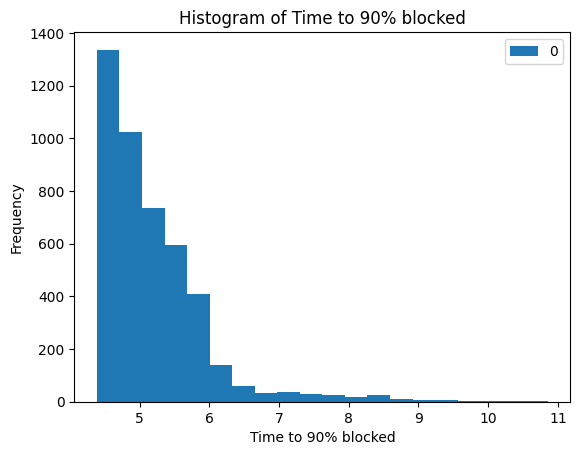

In [161]:
### Plot histogram of df_results[0]
high_results.plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

In [21]:
print(df.shape)
print(df_results.shape)

(8998, 2295)
(8998, 1)


In [162]:
### create an x and y from df and df_results
X = high_inputs.values
y = high_results.values

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [163]:
print(f"X_train_tensor shape: {X_train_tensor.shape}")  # Expected: (train_samples, num_features)
print(f"y_train_tensor shape: {y_train_tensor.shape}")  # Expected: (train_samples, 1)
print(f"X_test_tensor shape: {X_test_tensor.shape}")    # Expected: (test_samples, num_features)
print(f"y_test_tensor shape: {y_test_tensor.shape}")    # Expected: (test_samples, 1)


X_train_tensor shape: torch.Size([3599, 2295])
y_train_tensor shape: torch.Size([3599, 1, 1])
X_test_tensor shape: torch.Size([900, 2295])
y_test_tensor shape: torch.Size([900, 1, 1])


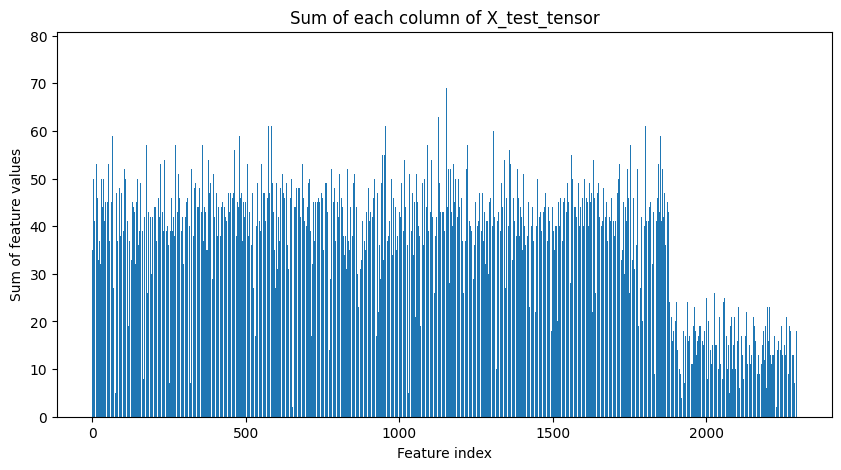

In [164]:
### plot sum of each column of X_test_tensor
plt.figure(figsize=(10, 5))
plt.bar(range(X_test_tensor.shape[1]), X_test_tensor.sum(dim=0))
plt.xlabel("Feature index")
plt.ylabel("Sum of feature values")
plt.title("Sum of each column of X_test_tensor")
plt.show()


In [165]:
num_epochs = 10

for epoch in range(num_epochs):
    attn_model.train()  # Set model to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = attn_model(binary_input_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

In [166]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, output_dim, max_len=5000):
        super(TransformerRegressor, self).__init__()
        # Linear layer to project input_dim to d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output regression layer
        self.regressor = nn.Linear(d_model, output_dim)

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debug input shape

        # Project input to d_model dimension
        x = self.embedding(x)  # Shape: (batch_size, seq_len, d_model)

        # Add positional encoding
        x = self.positional_encoding(x)  # Shape: (batch_size, seq_len, d_model)

        # Transformer expects input of shape (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, d_model)

        # Pass through the transformer
        x = self.transformer(x)  # Shape: (seq_len, batch_size, d_model)

        # Aggregate along the sequence dimension (mean pooling)
        x = x.permute(1, 0, 2).mean(dim=1)  # Shape: (batch_size, d_model)

        # Final regression layer
        x = self.regressor(x)  # Shape: (batch_size, output_dim)
        return x

    def _positional_encoding(self, x):
        # Positional encoding for feature dimension
        seq_len, d_model = x.size(1), x.size(2)
        pe = torch.zeros(1, seq_len, d_model)
        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[0, pos, i] = torch.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[0, pos, i + 1] = torch.cos(pos / (10000 ** ((2 * i) / d_model)))
        return pe.to(x.device)

In [167]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        print(f"Input x type: {type(x)} and shape: {x.shape}")
        seq_len = x.size(1)  # Match sequence length
        encoding = self.encoding[:, :seq_len, :].to(x.device)
        return encoding

In [168]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [169]:
import math

x = torch.rand(32, 10, 128)
pe = PositionalEncoding(d_model=128)
pos_encoded = pe(x)
print(pos_encoded.shape)  # Expected: (32, 10, 128)

Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 10, 128])
torch.Size([1, 10, 128])


In [170]:
X_train_tensor.shape

torch.Size([3599, 2295])

In [171]:
input_dim = X.shape[1]
output_dim = 1

In [172]:
def forward(self, x):
    print(f"Input shape: {x.shape}")  # Debug
    
    # Add sequence dimension if missing
    if len(x.shape) == 2:  # (batch_size, input_dim)
        x = x.unsqueeze(1)  # (batch_size, 1, input_dim)
    
    x = self.embedding(x)  # Linear layer to match d_model
    print(f"After embedding: {x.shape}")  # Debug
    
    # Apply positional encoding
    pos_enc = self._positional_encoding(x)  # Generate positional encoding
    print(f"Positional encoding shape: {pos_enc.shape}")  # Debug
    
    x = x + pos_enc  # Add positional encoding
    print(f"After positional encoding: {x.shape}")  # Debug
    
    x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
    x = self.transformer(x)  # Transformer processing
    x = x.permute(1, 0, 2).mean(dim=1)  # Back to (batch_size, d_model)
    x = self.regressor(x)  # (batch_size, output_dim)
    return x





In [173]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(input_dim=input_dim, d_model=512, num_heads=16, num_layers=8, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()



#forward(model, X_train_tensor[:2])


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [174]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x ty

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x ty

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Train Loss: 0.9308, Test Loss: 0.4969
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 5

TransformerRegressor(
  (embedding): Linear(in_features=2295, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)

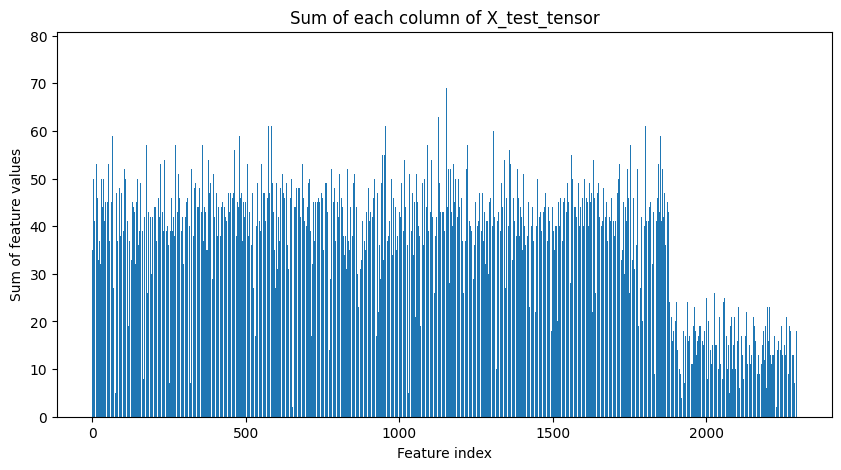

In [175]:
### Plot the sum of each column of X_test_tensor
plt.figure(figsize=(10, 5))
plt.bar(range(X_test_tensor.shape[1]), X_test_tensor.sum(dim=0))
plt.xlabel("Feature index")
plt.ylabel("Sum of feature values")
plt.title("Sum of each column of X_test_tensor")
plt.show()

In [184]:
### create an example input of all 1s
example_ones_input = torch.ones(1, X_test_tensor.shape[1])
### create an example input of all 0s
example_zeros_input = torch.zeros(1, X_test_tensor.shape[1])

model.eval()
with torch.no_grad():
    example_output = model(example_ones_input)
    print(f"Example output: {example_output.item()}")

    example_output = model(example_zeros_input)
    print(f"Example output: {example_output.item()}")

print(example_ones_input)
print(example_zeros_input)

Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Example output: 5.364516735076904
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Example output: 5.364516735076904
tensor([[1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


In [176]:
y_true = y_test_tensor.squeeze().numpy()
predictions = []
with torch.no_grad():
    model.eval()
    for i in range(X_test_tensor.shape[0]):
        sample = X_test_tensor[i].unsqueeze(0)
        pred = model(sample)
        pred = pred.squeeze().item()
        predictions.append(pred)    

Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.T

In [177]:
print(len(predictions), len(y_true))

900 900


In [181]:
predictions

[5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,


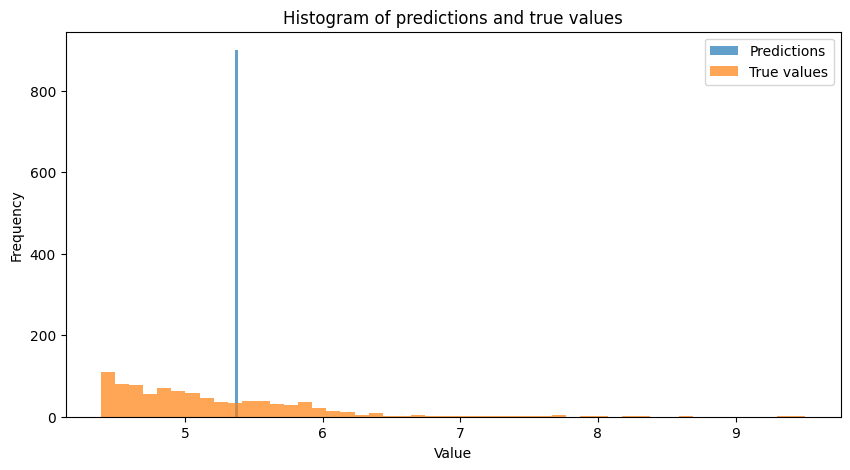

In [179]:
### plot histogram of predictions
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=50, alpha=0.7, label="Predictions")
plt.hist(y_true, bins=50, alpha=0.7, label="True values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of predictions and true values")
plt.legend()
plt.show()


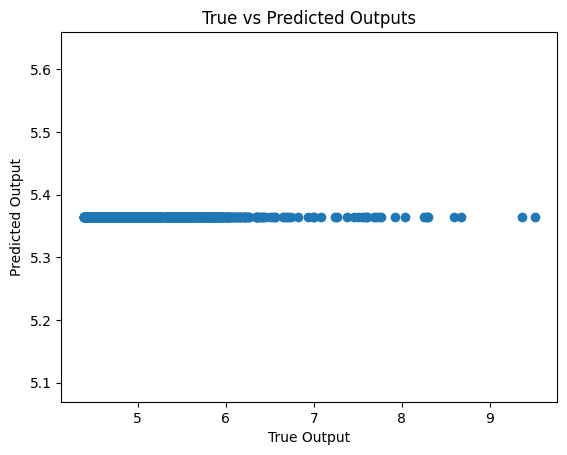

In [180]:
import matplotlib.pyplot as plt

plt.scatter(y_test_tensor, predictions)
plt.xlabel("True Output")
plt.ylabel("Predicted Output")
plt.title("True vs Predicted Outputs")
plt.show()


In [134]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        all_preds = []
        all_targets = []
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            all_preds.append(output)
            all_targets.append(target)
        
        # Calculate Mean Squared Error
        test_loss /= len(test_loader)
        print(f'Test Loss: {test_loss}')

        # Convert list to tensors
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        return all_preds, all_targets

# Evaluate the model
predictions, targets = evaluate_model(model, test_loader)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x ty

In [135]:
predictions

array([[4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.